### Experiment 2 - Simulated mutated references, simulate raw data, align raw data to mutated references

In [61]:
from Bio import SeqIO
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [62]:
# read the original NCBI reference sequence

#filename = "../refs/rhinovirus_NC_001617.fasta" #"chkv_NC_004162.fasta" #"GCF_900618125.1_NCTC11032_genomic.fna"
filename = "../refs/chkv_NC_004162.fasta"
#filename = "../refs/GCF_900618125.1_NCTC11032_genomic.fna"

original_record = SeqIO.read(filename, "fasta") # NOTE: this only works with single-sequence .fasta files

id_thresholds = [0.99, 0.97, 0.95, 0.92, 0.9, 0.85, 0.8]  # specified list of thresholds

def mutate_sequence(sequence, pid):
    '''
    Given a sequence and a % ID threshold, mutate the sequence at random positions to produce
    a new sequence with the specified % ID. Return the new sequence string.
    '''
    
    swap_values = ['A','C','G','T']
    
    len_of_seq = len(sequence)
    num_bp_to_change = (np.round(len_of_seq) * (1-pid))
    all_bp_locs = [b for b in range(len_of_seq)]    
    bp_locs_to_change = random.sample(all_bp_locs, int(num_bp_to_change))
    
    # loop through indices of bases to change and swap out values
    new_seq = list(sequence)
    for bp in bp_locs_to_change:
        new_seq[bp] = random.sample([i for i in swap_values if i != new_seq[bp] ], 1)[0]
        
    return("".join(new_seq))

# currate a dictionary of mutated sequences at specified %ID thresholds
sequence_dict = {original_record.id : original_record.seq}
for i in id_thresholds:
    for j in range(1):
        this_seq = mutate_sequence(original_record.seq, i)
        sequence_dict[str(i) + '-' + str(j+1)] = this_seq
        
# write the mutated sequences to a fasta file

for s in sequence_dict:
    with open( s + ".ref.fasta", 'w') as f: 
        f.write('>' + s + '\n' + str(sequence_dict[s]) + '\n')
    f.close()

In [63]:
# simulate sequences from the input file
! iss generate --genomes {filename} --model miseq --output miseq_reads --n_reads 100000

INFO:iss.app:Starting iss generate
INFO:iss.app:Using kde ErrorModel
INFO:iss.util:Stitching input files together
INFO:iss.app:Using lognormal abundance distribution
INFO:iss.app:Using 2 cpus for read generation
INFO:iss.app:Generating 100000 reads
INFO:iss.app:Generating reads for record: NC_004162.2
INFO:iss.util:Stitching input files together
INFO:iss.util:Stitching input files together
INFO:iss.util:Cleaning up
INFO:iss.app:Read generation complete


In [64]:
# run minimap2

result_dictionary = {}

for i in sequence_dict:
    this_ref = str(i) + ".ref.fasta"

    # note: this is the minimap2 command used in CZ ID short-read-mngs workflow
    ! minimap2 -ax sr {this_ref} miseq_reads_R1.fastq miseq_reads_R2.fastq > aln.sam
    ! samtools stats aln.sam > alnstats.txt
    unmapped_reads_string = ! grep "reads unmapped:" alnstats.txt
    unmapped_reads_count = int(unmapped_reads_string[0].split(':')[-1].strip())
    
    result_dictionary[i] = unmapped_reads_count

[M::mm_idx_gen::0.001*22.49] collected minimizers
[M::mm_idx_gen::0.002*13.67] sorted minimizers
[M::main::0.002*13.51] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.002*13.48] mid_occ = 1000
[M::mm_idx_stat] kmer size: 21; skip: 11; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.002*12.75] distinct minimizers: 1973 (100.00% are singletons); average occurrences: 1.000; average spacing: 5.994; total length: 11826
[M::worker_pipeline::1.380*2.36] mapped 100000 sequences
[M::main] Version: 2.22-r1101
[M::main] CMD: minimap2 -ax sr NC_004162.2.ref.fasta miseq_reads_R1.fastq miseq_reads_R2.fastq
[M::main] Real time: 1.381 sec; CPU: 3.257 sec; Peak RSS: 0.080 GB
[M::mm_idx_gen::0.001*20.58] collected minimizers
[M::mm_idx_gen::0.002*12.69] sorted minimizers
[M::main::0.002*12.53] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.002*12.50] mid_occ = 1000
[M::mm_idx_stat] kmer size: 21; skip: 11; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.002*11.81] distinct 

NC_004162.2        2
0.99-1             7
0.97-1           129
0.95-1          1395
0.92-1         13091
0.9-1          36683
0.85-1         81276
0.8-1          96206
dtype: int64
NC_004162.2    0.00002
0.99-1         0.00007
0.97-1         0.00129
0.95-1         0.01395
0.92-1         0.13091
0.9-1          0.36683
0.85-1         0.81276
0.8-1          0.96206
dtype: float64


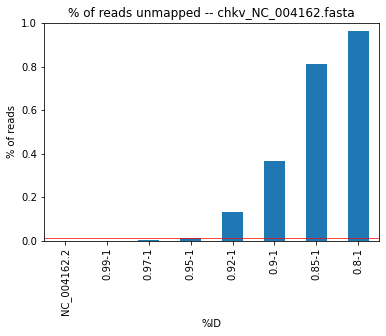

In [65]:
ser = pd.Series(result_dictionary)
print(ser)
print(ser/100000)

graph = (ser/100000).plot(kind='bar', title='% of reads unmapped -- ' + filename.split('/')[-1], 
                          ylabel = "% of reads", xlabel = "%ID",
                         ylim = (0,1))
graph.axhline(0.01, lw=.7, color='red')
plt.show()